In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

from plotnine import *

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# LLVM

In [5]:
llvm_ssa = pd.read_csv('data/count_SSA.csv')

FileNotFoundError: File b'data/count_SSA.csv' does not exist

In [6]:
stores = pd.read_csv('data/stores.csv')
stores = stores.join(llvm_ssa['STORE'])
stores = stores.reset_index(drop=True)
stores['stores_total'] = stores['store_before'] + stores['store_main'] + stores['store_end']
stores['visible'] = stores.STORE/stores.stores_total
stores['invisible'] = 1 - stores.visible
stores['group'] = stores.Benchmark.apply(lambda x: x.split('/')[1])

In [7]:
stores.head()

,Benchmark,store_before,store_main,store_end,STORE,stores_total,visible,invisible,group
0,Benchs/SciMark2-C,11832,27078038364,176,21794063853,27078050372,0.805,0.195,SciMark2-C
1,Benchs/Ptrdist/anagram,11983,530739254,0,339525631,530751237,0.640,0.360,Ptrdist
2,Benchs/Ptrdist/bc,12091,475329588,0,68676000,475341679,0.144,0.856,Ptrdist
3,Benchs/Ptrdist/yacr2,11898,162988574,0,75431380,163000472,0.463,0.537,Ptrdist
4,Benchs/Ptrdist/ks,11895,107714801,0,275928,107726696,0.003,0.997,Ptrdist


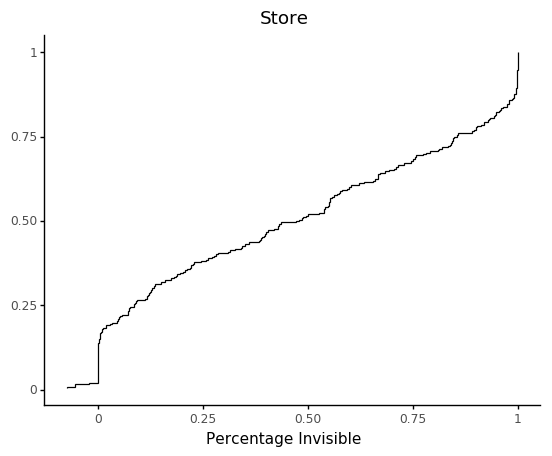

<ggplot: (288281818)>

In [8]:
(ggplot(stores, aes(x='invisible'))
#  + geom_histogram(color='white', bins=15)
 + stat_ecdf()
 + ggtitle('Store')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

# Loads

In [9]:
loads = pd.read_csv('data/loads.csv')
loads = loads.join(llvm_ssa['LOAD'])
loads['load_total'] = loads['load_before'] + loads['load_main'] + loads['load_end']
loads = loads.reset_index(drop=True)
loads['visible'] = loads.LOAD/loads.load_total
loads['invisible'] = 1 - loads.visible

In [10]:
loads.head()

,Benchmark,load_before,load_main,load_end,LOAD,load_total,visible,invisible
0,Benchs/SciMark2-C,26606,70153741269,338,63720918615,70153768213,0.908,0.092
1,Benchs/Ptrdist/anagram,26915,1764833842,0,1419533456,1764860757,0.804,0.196
2,Benchs/Ptrdist/bc,27229,744882158,0,241468747,744909387,0.324,0.676
3,Benchs/Ptrdist/yacr2,26731,1396114232,0,1251050300,1396140963,0.896,0.104
4,Benchs/Ptrdist/ks,26715,2039468319,0,2033878467,2039495034,0.997,0.003


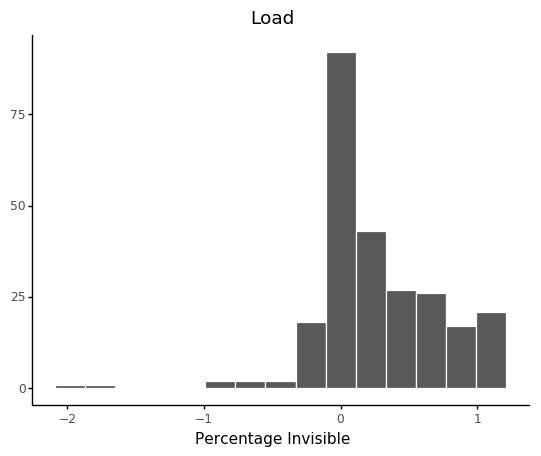

<ggplot: (-9223372036566419333)>

In [11]:
(ggplot(loads, aes(x='invisible'))
 + geom_histogram(color='white', bins=15)
 + ggtitle('Load')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

In [12]:
(ggplot(loads.reset_index(), aes('invisible'))
 + geom_line(aes(y='1-y'), stat='identity')
)

PlotnineError: "Could not evaluate the 'y' mapping: '1-y' (original error: name 'y' is not defined)"

# BR

In [13]:
br = pd.read_csv('data/br.csv')
br = br.join(llvm_ssa['BR'])
br['visible'] = br.BR/(br.br_main + br.indirect_main)
br['invisible'] = 1 - br.visible

In [14]:
br.head()

,Benchmark,br_before,br_main,br_end,indirect_before,indirect_main,indirect_end,BR,visible,invisible
0,Benchs/SciMark2-C,17350,32177688456,235,262,5243290,1,29713587203,0.923,0.077
1,Benchs/Ptrdist/anagram,17518,739031597,0,260,45025189,0,353057135,0.450,0.550
2,Benchs/Ptrdist/bc,17728,511350018,0,263,17341009,0,133611424,0.253,0.747
3,Benchs/Ptrdist/yacr2,17407,2290534856,0,255,556769,0,1617929101,0.706,0.294
4,Benchs/Ptrdist/ks,17406,1443227540,0,260,15539,0,1441645329,0.999,0.001


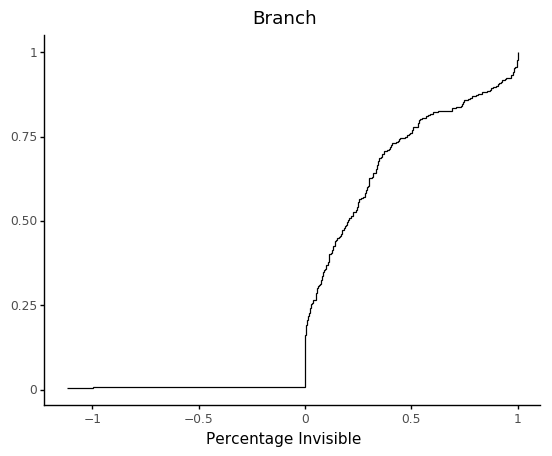

<ggplot: (289617300)>

In [80]:
(ggplot(br, aes(x='invisible'))
#  + geom_histogram(color='white', bins=15)
 + stat_ecdf()
 + ggtitle('Branch')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

# binops

In [18]:
binops = pd.read_csv('data/binops.csv')

for t in ['ADD', 'DIV', 'MUL', 'FADD', 'FMUL', 'SUB']:
    binops[t + '_total'] = binops[t + '_before'] + binops[t + '_main'] + binops[t + '_end']

In [85]:
def get(t):
    dfx = pd.DataFrame(binops[[t + '_before', t + '_main', t + '_end', 'Benchmark']])
    dfx[t + '_total'] = dfx[t + '_before'] + dfx[t + '_main'] + dfx[t + '_end']
    dfx = dfx.merge(llvm_ssa[[t, 'Benchmark']], how='inner', on='Benchmark')
    dfx = dfx.reset_index(drop=True)
    dfx['visible'] = dfx[t]/dfx[t + '_total']
    dfx['invisible'] = 1 - dfx.visible
    dfx['group'] = dfx.Benchmark.apply(lambda x: x.split('/')[1])
    dfx.fillna(0, inplace=True)
    dfx.replace(-np.inf, 0, inplace=True)
    
    return dfx

## ADD - SUB

In [82]:
sub = get('SUB')

In [21]:
sub.head()

,SUB_before,SUB_main,SUB_end,Benchmark,SUB_total,SUB,visible,invisible,group
0,5007,8139232671,93,Benchs/SciMark2-C,8139237771,4959620900,0.609,0.391,SciMark2-C
1,5023,364900327,0,Benchs/Ptrdist/anagram,364905350,287844283,0.789,0.211,Ptrdist
2,5082,257821764,0,Benchs/Ptrdist/bc,257826846,23490320,0.091,0.909,Ptrdist
3,4949,21741687,0,Benchs/Ptrdist/yacr2,21746636,1907480,0.088,0.912,Ptrdist
4,4975,273326,0,Benchs/Ptrdist/ks,278301,1179,0.004,0.996,Ptrdist


In [24]:
add = get('ADD')

In [25]:
add.head()

,ADD_before,ADD_main,ADD_end,Benchmark,ADD_total,ADD,visible,invisible,group
0,10428,27182951770,43,Benchs/SciMark2-C,27182962241,37254806248,1.371,-0.371,SciMark2-C
1,10521,393316961,0,Benchs/Ptrdist/anagram,393327482,85539577,0.217,0.783,Ptrdist
2,10611,201190043,0,Benchs/Ptrdist/bc,201200654,88226679,0.439,0.561,Ptrdist
3,10472,1090525386,0,Benchs/Ptrdist/yacr2,1090535858,1280156140,1.174,-0.174,Ptrdist
4,10461,582677,0,Benchs/Ptrdist/ks,593138,260357,0.439,0.561,Ptrdist


In [47]:
addsub = pd.merge(add[['Benchmark', 'ADD', 'ADD_total']], sub[['SUB', 'SUB_total', 'Benchmark', 'group']], on='Benchmark')
addsub['visible'] = (addsub['ADD'] + addsub['SUB'])/(addsub['ADD_total'] + addsub['SUB_total'])
addsub['invisible'] = 1 - addsub['visible']

In [48]:
addsub.head()

,Benchmark,ADD,ADD_total,SUB,SUB_total,group,visible,invisible
0,Benchs/SciMark2-C,37254806248,27182962241,4959620900,8139237771,SciMark2-C,1.195,-0.195
1,Benchs/Ptrdist/anagram,85539577,393327482,287844283,364905350,Ptrdist,0.492,0.508
2,Benchs/Ptrdist/bc,88226679,201200654,23490320,257826846,Ptrdist,0.243,0.757
3,Benchs/Ptrdist/yacr2,1280156140,1090535858,1907480,21746636,Ptrdist,1.153,-0.153
4,Benchs/Ptrdist/ks,260357,593138,1179,278301,Ptrdist,0.300,0.700


In [52]:
addsub.query('invisible < -10')

,Benchmark,ADD,ADD_total,SUB,SUB_total,group,visible,invisible
22,Benchs/cpu2006/470.lbm/rbc,337321303626,4040836856,0,7945694,cpu2006,83.314,-82.314


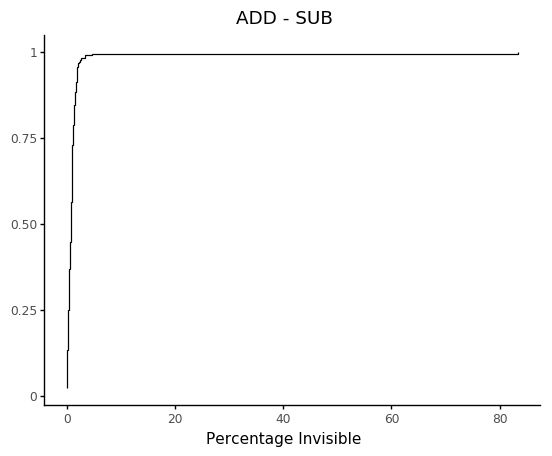

<ggplot: (-9223372036565148342)>

In [62]:
(ggplot(addsub, aes(x='visible'))
 + stat_ecdf()
 + ggtitle('ADD - SUB')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## ADD

In [110]:
add = get('ADD')

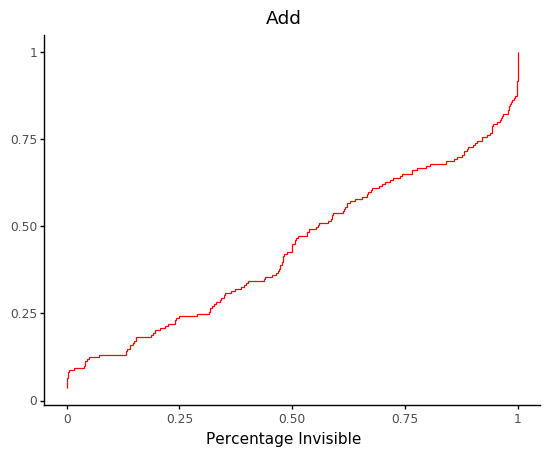

<ggplot: (289422989)>

In [59]:
(ggplot(add[add.invisible >= 0], aes(x='visible'))
 + stat_ecdf(color='red')
#  + scale_x_log10()
 + ggtitle('Add')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## CMP

In [116]:
cmp = get('CMP')

/Users/guilhermeleobas/Library/Python/3.7/lib/python/site-packages/plotnine/layer.py:363: UserWarning: stat_bin : Removed 93 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


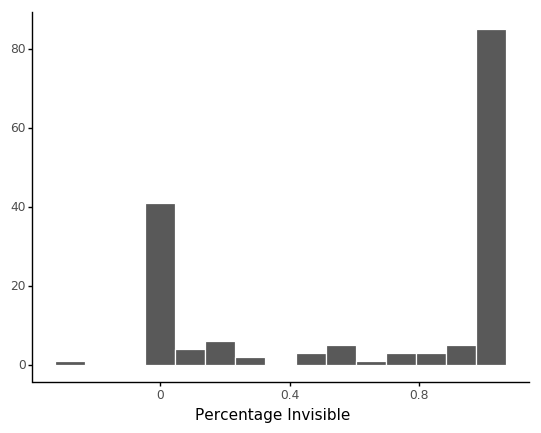

<ggplot: (287017378)>

In [115]:
(ggplot(cmp, aes(x='invisible'))
 + geom_histogram(color='white', bins=15)
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

In [120]:
x[x.invisible < -10]

,OR_before,OR_main,OR_end,Benchmark,OR_total,OR,visible,invisible,group
76,296,18,3,Benchs/Misc/salsa20,317,10758390080,33938139.054,-33938138.054,Misc


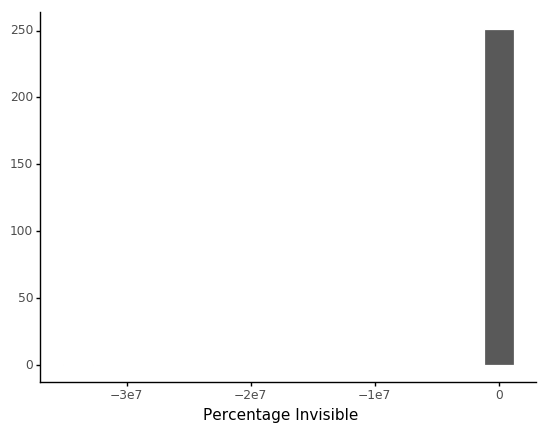

<ggplot: (287036641)>

In [117]:
x = get('OR')
(ggplot(x, aes(x='invisible'))
 + geom_histogram(color='white', bins=15)
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## Div

In [39]:
div = get('DIV')

/Users/guilhermeleobas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: 'DIV'

In [ ]:
(ggplot(div[div.invisible > 0], aes(x='invisible'))
 + geom_histogram(color='white', bins=15)
 + ggtitle('DIV')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## MUL

In [40]:
mul = get('MUL')

/Users/guilhermeleobas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


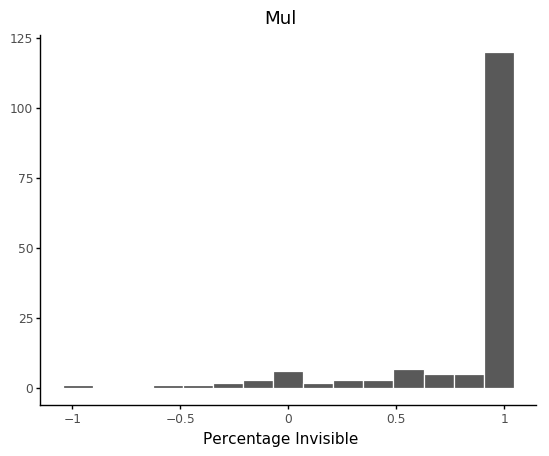

<ggplot: (285801213)>

In [41]:
(ggplot(mul[mul.invisible > -1], aes(x='invisible'))
 + geom_histogram(color='white', bins=15)
 + ggtitle('Mul')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## FADD

In [74]:
fadd = get('FADD')

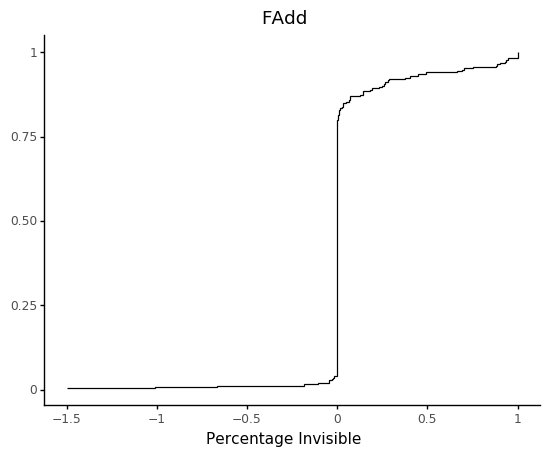

<ggplot: (289986515)>

In [75]:
(ggplot(fadd, aes(x='invisible'))
 + stat_ecdf()
 + ggtitle('FAdd')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)

## FMUL

In [86]:
fmul = get('FMUL')

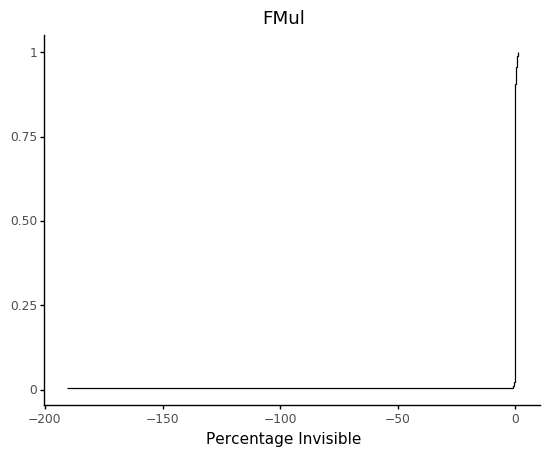

<ggplot: (-9223372036565349004)>

In [88]:
(ggplot(fmul, aes(x='invisible'))
 + stat_ecdf()
 + ggtitle('FMul')
 + ylab('')
 + xlab('Percentage Invisible')
 + theme_classic()
)